In [1]:
import numpy as np
import pickle
import scipy.ndimage
import matplotlib.pyplot as plt
import math

In [2]:
track = pickle.load(open("track.pkl"))

track = track[:-14,:]
print track

[[ 120.   39.]
 [ 120.   39.]
 [ 120.   39.]
 ..., 
 [ 122.   47.]
 [ 122.   47.]
 [ 122.   47.]]


In [3]:
def jumps(vals):
    
    return [t for t in range(1,len(vals)) if  np.abs(vals[t]-vals[t-1]) > 1]

def samey_intervals(vals, t_window=5):
    last = vals[0]
    start = -1
    accum = 0
    intervals = []
    
    for t, v in enumerate(vals):
        
        if v == last:
            accum += 1            
        else:
            if accum > t_window:
                intervals.append(t-1)
                intervals.append(t)
                intervals.append(t+1)
                intervals.append(t-accum-1)
                intervals.append(t-accum)
                intervals.append(t-accum+1)
            accum = 0

        last = v
    return intervals


def zero_crossings(vals):    

    sign_intervals = []
    last_sign_change = 0
    vsigns = np.sign(vals)
    last_sign = vsigns[0]    
    zeros = np.zeros(vsigns.shape)
    zeros[vsigns == 0] = 1
    accum = 0

    for t in range(len(zeros)):        
        if zeros[t] == 1:
            accum += 1
        else:
            accum = 0
        zeros[t] = accum
    last = 0

    for t,v in enumerate(zeros):
        if v == 1:
            sign_intervals.append(t)
            sign_intervals.append(t-1)
        elif v == 0 and last > 5:
            sign_intervals.append(t)
            sign_intervals.append(t-1)
        last = v

    return sorted(set(sign_intervals))

In [4]:
velocities = track[1:,1]-track[:-1,1]
all_times = range(len(velocities))

print len(velocities)

same_window = 6

switch_points = set(zero_crossings(velocities))

samey_points = set(samey_intervals(velocities,t_window=same_window))


def button_change_times(button_masks):
    last_mask = 0
    mask_times = []
    # Note: for a temporary optimization we could drop certain buttons?
    for t,b in enumerate(button_masks):
        if b != last_mask:
            mask_times.append(t)
            last_mask = b
    return mask_times
input1,input2 = pickle.load(open('inputs.pkl'))

print input1

985
[130L, 130L, 130L, 130L, 130L, 130L, 130L, 130L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 130L, 130L, 130L, 130L, 130L, 130L, 130L, 130L, 130L, 130L, 2L, 2L, 2L, 2L, 2L, 3L, 3L, 3L, 3L, 3L, 67L, 67L, 67L, 67L, 67L, 67L, 67L, 67L, 67L, 67L, 66L, 66L, 66L, 66L, 66L, 66L, 66L, 66L, 66L, 66L, 66L, 66L, 66L, 66L, 66L, 66L, 66L, 66L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 3L, 3L, 3L, 3L, 3L, 3L, 3L, 3L, 3L, 3L, 3L, 3L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 130L, 130L, 130L, 130L, 130L, 130L, 130L, 130L, 130L, 130L, 130L, 130L, 130L, 130L, 130L, 130L, 130L, 130L, 130L, 130L, 130L, 130L, 130L, 130L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 3L, 3L, 3L, 3L, 3L, 3L, 3L, 3L, 3L, 3L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 3L, 3L, 3L, 3L, 3L, 3L, 3L, 3L, 3L, 3L, 3L,

In [5]:
button_times = set(button_change_times(input1)) | set(button_change_times(input2))

In [6]:
velocity_times = switch_points | samey_points | set(jumps(velocities))


all_times = sorted(button_times | velocity_times) + [len(velocities)-1]
print all_times

[-1, 0, 1, 8, 31, 41, 45, 46, 47, 51, 61, 65, 66, 73, 74, 75, 79, 85, 86, 87, 91, 103, 106, 107, 108, 109, 116, 124, 126, 130, 131, 142, 143, 144, 145, 154, 163, 164, 165, 173, 174, 186, 187, 188, 189, 209, 210, 211, 219, 220, 227, 232, 233, 234, 235, 268, 297, 303, 330, 331, 332, 347, 348, 354, 355, 356, 359, 360, 363, 364, 367, 368, 371, 372, 375, 376, 379, 380, 383, 384, 387, 388, 391, 392, 393, 394, 395, 407, 408, 409, 410, 411, 430, 431, 432, 433, 434, 441, 442, 443, 460, 461, 463, 464, 471, 472, 475, 476, 477, 478, 485, 486, 487, 495, 500, 501, 508, 509, 510, 525, 526, 527, 531, 553, 554, 555, 558, 560, 563, 564, 565, 577, 578, 579, 584, 585, 593, 594, 595, 599, 625, 626, 627, 628, 634, 635, 636, 637, 638, 647, 648, 649, 674, 675, 677, 678, 680, 685, 686, 687, 710, 711, 712, 715, 717, 719, 721, 723, 724, 725, 726, 727, 749, 753, 754, 755, 780, 781, 782, 783, 789, 790, 791, 792, 796, 814, 815, 816, 817, 834, 835, 836, 837, 858, 859, 860, 875, 877, 878, 880, 887, 888, 889, 890, 892

In [7]:
'''def make_inputs(start,end,input_type):
    end = all_times[end]
    start = all_times[start]
    interval = end-start
    data = np.zeros((interval,1))
    
    vels =14 np.copy(velocities[start:end])
    if input_type in ['cN','accN']:
        data = np.hstack((data,np.ones((interval,1))))
    if input_type in ['acc0','accP','accN']:
        dat = np.ones((interval,1))
        for ii in range(interval):
            dat[ii,0] = ii
            
        data = np.hstack((data,dat))
    if input_type in ['accP','cP']:
        begin = velocities[start-1]
        vels -= begin
    return data, vels
'''
def make_inputs(start,end,input_type):
    end = all_times[end]
    start = all_times[start]
    interval = end-start
    
    if input_type in ['c0']:
        data = np.zeros((interval,1))
    elif input_type in ['acc0']:
        dat = np.ones((interval,1))
        for ii in range(interval):
            dat[ii,0] = ii
        data = dat
    else:
        data = np.ones((interval,1))
    
    vels = np.copy(velocities[start:end])
    if input_type in ['accP','accN']:
        dat = np.ones((interval,1))
        for ii in range(interval):
            dat[ii,0] = ii
            
        data = np.hstack((data,dat))
    return data, vels

Points: 219
[0, 1, 8, 31, 41, 45, 46, 47, 51, 61, 65, 66, 73, 74, 75, 79, 85, 86, 87, 91, 103, 106, 107, 108, 109, 116, 124, 126, 130, 131, 142, 143, 144, 145, 154, 163, 164, 165, 173, 174, 186, 187, 188, 189, 209, 210, 211, 219, 220, 227, 232, 233, 234, 235, 268, 297, 303, 330, 331, 332, 347, 348, 354, 355, 356, 359, 360, 363, 364, 367, 368, 371, 372, 375, 376, 379, 380, 383, 384, 387, 388, 391, 392, 393, 394, 395, 407, 408, 409, 410, 411, 430, 431, 432, 433, 434, 441, 442, 443, 460, 461, 463, 464, 471, 472, 475, 476, 477, 478, 485, 486, 487, 495, 500, 501, 508, 509, 510, 525, 526, 527, 531, 553, 554, 555, 558, 560, 563, 564, 565, 577, 578, 579, 584, 585, 593, 594, 595, 599, 625, 626, 627, 628, 634, 635, 636, 637, 638, 647, 648, 649, 674, 675, 677, 678, 680, 685, 686, 687, 710, 711, 712, 715, 717, 719, 721, 723, 724, 725, 726, 727, 749, 753, 754, 755, 780, 781, 782, 783, 789, 790, 791, 792, 796, 814, 815, 816, 817, 834, 835, 836, 837, 858, 859, 860, 875, 877, 878, 880, 887, 888, 889, 

/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<IPython.core.display.Javascript object>


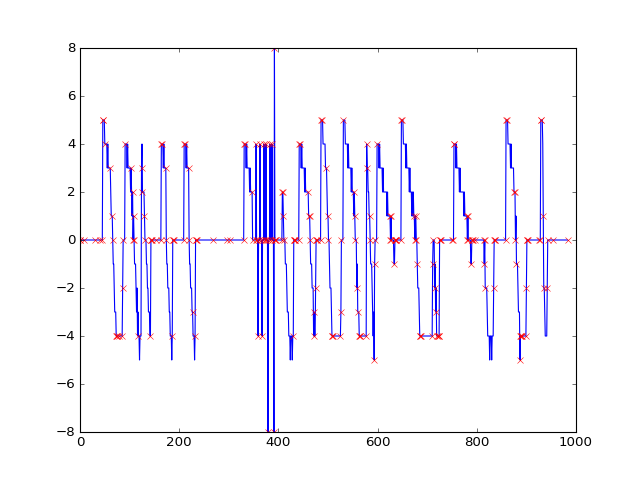

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218


In [8]:
%matplotlib notebook 
import statsmodels.api as sm

all_times = [t for t in all_times if (t >= 0 and t < len(velocities))]

likes = [None]*len(all_times)

print "Points:",len(all_times)
print all_times
plt.plot(velocities[:all_times[-1]])
plt.plot(np.array(all_times),velocities[np.array(all_times,dtype='int')],'rx')
plt.show()

# Takahashi Meijin constant, 60 frames / 16 inputs ~= 4 frames per input.
# But note that in general transitions may happen more frequently due to collisions, etc.
min_interval = 3
max_interval = len(all_times)

likes = [None]*len(all_times)
for i in range(0,len(all_times)):
    print i
    likes[i] = [None]*len(all_times)
    t0 = all_times[i]
    min_likelihood = float('inf')
    for j in [j for j in range(i+1, len(all_times)) if all_times[j]-all_times[i] > min_interval and  all_times[j]-all_times[i] < max_interval]:
        models = {}
        if all_times[j]-all_times[i] > 1:
            for model in ['c0','cN','acc0','accN']:
                X,Y = make_inputs(i,j,model)
                ols = sm.OLS(Y,X,hasconst=False)
                results = ols.fit()
                models[model] = results
                
        likes[i][j] = models

#print ''

In [35]:
from scipy import stats

inp = []
def penalty(length,params):
    penalty_type = 'MDL' # 'BIC'
    if penalty_type == 'MDL':
        return 2*(1.0 + 0.5*np.log(length))*(params)
    if penalty_type == 'BIC':
        return 2*np.log(length)*(params)

In [36]:
%%time
modes = [(0,None)]*(len(all_times))
        
model_type_params = {'c0':0,
                    'cN':1,
                    'acc0':1,
                    'accN':2}

for m in model_type_params:
    model_type_params[m] += np.ceil(np.log2(len(model_type_params)))
    print m,model_type_params[m]
str_out = ''
regularization = 1

def score_model(length,model,model_type):
    crit = -model.model.loglike(model.params)
    if crit == -float('inf') or crit < 0:
        crit = -33*length #-2000*(length+1) #2000*log(0.1^2)-1/(2*0.1^2)
        
    cost = regularization*penalty(length,model_type_params[model_type])#penalty(all_times[-1]-all_times[0],model.params)
    return crit +  cost, crit,cost
                

print len(all_times)
for j in range(1, len(all_times)):
    least = float("inf")
    least_template = None
    for i in range(0, j):
        data = likes[i][j]
        if data:
            for model_type,model in data.items():
                    
                m_prev = modes[i][0]
                here,crit,cost = score_model(all_times[j]-all_times[i],model,model_type)
                here += m_prev 
                str_out += '{}, {}, {},  {}, {}, {}, {}\n'.format(all_times[i], all_times[j], crit, cost,here,least,model_type)
                if here < least:
                    
                    least = here
                    # prev_i,this_j,t0,t1,name,summary,criterion
                    least_template = (i,j,(model_type,model,crit))
    
                   
    modes[j] = (least, least_template)
with open('temp.txt','wb') as outfile:
    outfile.write(str_out)

accN 4.0
c0 2.0
cN 3.0
acc0 3.0
219
CPU times: user 2.27 s, sys: 12 ms, total: 2.28 s
Wall time: 2.28 s


In [37]:
%matplotlib notebook
def get_path(modes):
    mj = len(modes)-1
    path = [modes[mj]]
    while mj > 0:
        mj = modes[mj][1][0]
        path.append(modes[mj])
    return list(reversed(path))[1:]

path = get_path(modes)

models = {}

for ii, p in enumerate(path):
    current_model_type = p[1][2][0]
    current_model_params = p[1][2][1].params
    key = 0
    can_merge = p[1][2][2] < 0
        
    found_match = False
    if can_merge:
        for m in models:
            if m[0] == current_model_type and m[3]:
                diff = np.sum(np.power(np.array(m[1]) - p[1][2][1].params,2.0))
                if diff < 1e-6:
                    found_match = True
                    models[m].append(ii)
                    break
    if not found_match:
        if can_merge:
            current_key = (current_model_type,tuple(current_model_params),0,can_merge)
        else:
            current_key = (current_model_type,tuple(current_model_params),ii,can_merge)
        if current_key not in models:
            models[current_key] = []
        models[current_key].append(ii)

        
model2index = {m:i for i,m in enumerate(sorted(models))}
index2model = {i:m for i,m in enumerate(sorted(models))}


path2index = {}

for m in sorted(models):
    print m, models[m]
    for ii in models[m]:
        path2index[ii] = model2index[m] 
initial_segmentation = [path2index[ii]  for ii,p in enumerate(path)]
    
print initial_segmentation
       


data = []
for ii,p in enumerate(path):
    data.append([all_times[p[1][0]],ii*0.1+6])
    data.append([all_times[p[1][1]],ii*0.1+6])
    print ii,p[0],'\n',all_times[p[1][0]],all_times[p[1][1]],p[1][2][1].params,'\n'
    
#data = np.array(data)    
#plt.plot(velocities[:all_times[-1]])
#plt.plot(data[:,0],data[:,1])
#plt.plot(np.array(all_times),velocities[np.array(all_times,dtype='int')],'rx')
#plt.show()
    

('acc0', (-0.58333333333333315,), 53, False) [53]
('acc0', (-0.48351648351648352,), 38, False) [38]
('acc0', (-0.45714285714285707,), 30, False) [30]
('acc0', (-0.44210526315789467,), 48, False) [48]
('acc0', (-0.42615384615384622,), 11, False) [11]
('acc0', (-0.42615384615384622,), 14, False) [14]
('acc0', (-0.37402597402597404,), 33, False) [33]
('acc0', (-0.3675889328063241,), 23, False) [23]
('acc0', (-0.3214285714285714,), 40, False) [40]
('accN', (-1.7428571428571413, -0.15338345864661654), 45, False) [45]
('accN', (-0.25714285714285706, 0.028571428571428564), 0, True) [36]
('accN', (-0.17613636363636373, 0.0073313782991202368), 0, True) [44]
('accN', (0.81318681318681318, -0.4175824175824176), 8, False) [8]
('accN', (1.141304347826086, -0.30533596837944654), 20, False) [20]
('accN', (2.6794871794871802, -0.56293706293706292), 2, False) [2]
('accN', (3.4615384615384626, -0.53846153846153855), 26, False) [26]
('accN', (3.8571428571428594, -0.54285714285714359), 0, True) [32]
('acc

In [38]:
import random
def mutate(segmentation):    
    mutated = list(segmentation)
    if random.random() < 0.15:
        mutated[random.randint(0,len(segmentation)-1)] = random.randint(0,len(segmentation)-1)
    else:
        possibles = set(segmentation)
        old = random.choice(list(possibles))
        new = old
        while new == old:
            new = random.choice(list(possibles))
        for ii in range(len(segmentation)):
            if mutated[ii] == old:
                mutated[ii] = new
                
        
    return mutated
def crossover(seg1,seg2):
    crossover_point = random.randint(1,len(seg1)-2)
    return seg1[:crossover_point] + seg2[crossover_point:]



def find_best_model(merge,debug=False):
    best_score = float('inf')
    best_model = None
    best_type = None
    for model in ['c0','cN','acc0','accN']:
        merged_X  = []
        merged_Y  = []
        for index in merge:
            seg = path[index]

            X,Y = make_inputs(seg[1][0],seg[1][1],model)
            merged_X.append(X)
            merged_Y.append(Y.reshape(-1,1))
        if len(merged_X) > 1: 
            merged_X = reduce(lambda x,y: np.vstack((x,y)),merged_X)
            merged_Y = reduce(lambda x,y: np.vstack((x,y)),merged_Y)
        else:
            merged_X = merged_X[0]
            merged_Y = merged_Y[0]
        ols = sm.OLS(merged_Y,merged_X,hasconst=False)
        results = ols.fit()

        scored_model, crit,cost = score_model(len(merged_Y),results,model)
        if debug:
            print model,scored_model,results.params, crit,cost,len(merged_Y)
        if scored_model < best_score:
            best_score = scored_model
            best_model = results
            best_type = model
    return best_score,best_model,best_type
def score(segmentation):
    merged = {}
    for index,segment in enumerate(segmentation):
        if segment not in merged:
            merged[segment] = []
        merged[segment].append(index)
    sum_of_scores = 0
    for merge in merged:         
        best_score, _, _ = find_best_model(merged[merge])
        sum_of_scores += best_score
    return sum_of_scores

In [39]:
population = []
population_size = 100

for ii in range(population_size):    
    population.append(list(initial_segmentation))
    if ii > population_size*0.5:
        for jj in range(4):
            population[-1] = mutate(population[-1])
            

In [40]:
'''
#Wanted to make sure this actually worked
to_merge = [0,7,10,13,18,21,24,34,38,40,43,47]
member = list(range(len(path)))
for ii in range(len(member)):
    if ii in to_merge:
        member[ii] = 0
print score(member)
print score(list(range(len(path))))
'''
generations=  100

selection_probability = 0.5
keep = 20
            
crossover_count = 15
for generation in range(generations):
    print generation
    scored = {}
    for ii,member in enumerate(population):
        member_score = score(member)
        if member_score not in scored:
            scored[member_score] = []
        scored[member_score].append(member)
    
    ranked = []
    print sorted(scored)[0]
    for s in sorted(scored):
        ranked += scored[s]
    
    new_population = []
    for ii in range(keep):
        for member in ranked:
            if random.random() < selection_probability:
                new_population.append(member)
                break
    
        
    
    while len(new_population) != population_size:
        new_population.append(mutate(random.choice(new_population)))
        
    population = new_population
    
    
    

0
-15662.1023632
1
-15947.3782813
2
-15959.7842778
3
-15971.3651281
4
-15981.7824043
5
-15993.3978109
6
-16015.0935553
7
-16022.9162077
8
-16032.6309581
9
-16051.1101664
10
-16063.3774163
11
-16068.1010594
12
-16100.7021953
13
-16109.5296768
14
-16135.393611
15
-16153.1780765
16
-16171.6545232
17
-16171.6545232
18
-16183.3833603
19
-16187.2732006
20
-16190.2832052
21
-16190.4221138
22
-16190.4221138
23
-16190.4221138
24
-16190.4221138
25
-16190.4221138
26
-16190.4221138
27
-16190.4511914
28
-16190.4511914
29
-16197.7665628
30
-16197.7665628
31
-16197.7665628
32
-16199.7033343
33
-16199.7033343
34
-16202.6012034
35
-16202.6012034
36
-16202.6012034
37
-16202.6012034
38
-16202.6012034
39
-16202.6012034
40
-16202.6012034
41
-16202.6012034
42
-16202.6012034
43
-16202.6012034
44
-16202.6012034
45
-16202.6012034
46
-16202.6012034
47
-16202.6012034
48
-16202.6012034
49
-16202.6012034
50
-16202.6012034
51
-16202.6012034
52
-16202.6012034
53
-16202.6012034
54
-16202.6012034
55
-16202.6012034
56


10
c0 375.138485093 [ 0.] 361.144060546 13.9944245475 148
cN 309.45786313 [-2.19594595] 288.466226308 20.9916368213 148
acc0 257.817769921 [-0.30668693] 236.8261331 20.9916368213 148
accN 256.803239348 [-0.61490036 -0.24787579] 228.814390253 27.9888490951 148
4 accN [-0.61490036 -0.24787579]

c0 -13612.9531048 [ 0.] -13629 16.0468951859 413
cN -13604.9296572 [-0.02905569] -13629 24.0703427789 413
acc0 -13604.9296572 [-0.00014004] -13629 24.0703427789 413
accN -13596.9062096 [-0.05033938  0.00098423] -13629 32.0937903718 413
0 c0 [ 0.]

c0 63.7301534083 [ 0.] 53.2924017585 10.4377516497 25
cN 68.9297836558 [-0.08] 53.2731561812 15.6566274746 25
acc0 64.5975520446 [-0.16262976] 48.94092457 15.6566274746 25
accN 42.8143923131 [ 3.03282705 -0.54042136] 21.9388890136 20.8755032995 25
2 accN [ 3.03282705 -0.54042136]

c0 22.0054720771 [ 0.] 14.4219531386 7.58351893846 6
cN 19.6278754759 [ 2.5] 8.25259706826 11.3752784077 6
acc0 24.5890701552 [ 0.50909091] 13.2137917475 11.3752784077 6
accN -

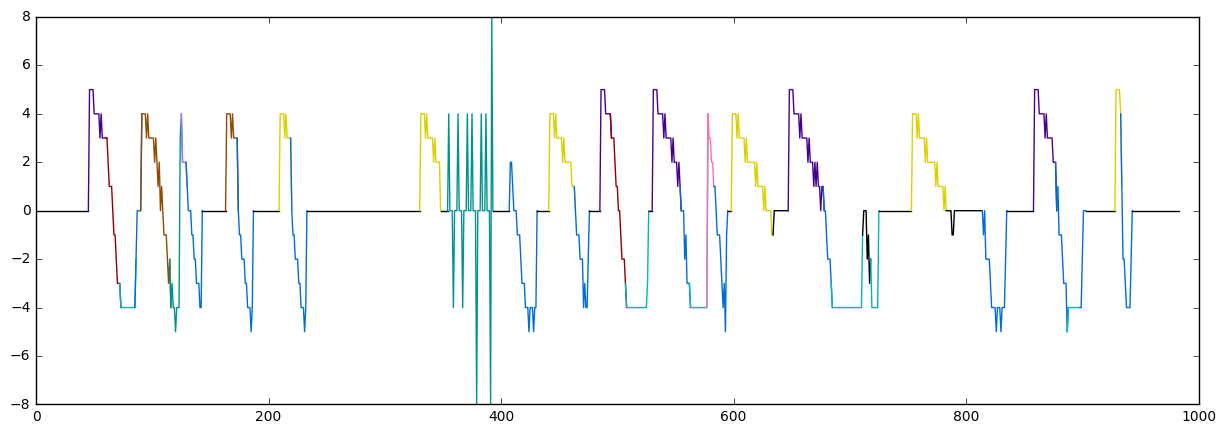

"\nplt.figure(figsize=(15,5))\nplt.plot(velocities[:all_times[-1]])\nplt.plot(mode_assignment[:,0],mode_assignment[:,1])\nplt.plot(np.array(all_times),velocities[np.array(all_times,dtype='int')],'rx')\nplt.show()\n"

In [70]:

%matplotlib inline
best = ranked[0]
if False:
    #-242000  -- 35
    best = [0, 1, 2, 3, 4, 5, 4, 6, 2, 0, 1, 2, 0, 1, 2, 0, 1,
            0, 4, 0, 7, 0, 1, 2, 0, 1, 2, 8, 0, 1, 2, 9, 4, 0, 1, 
            0, 1, 2, 10, 7, 9, 0, 1, 0, 7, 0, 1, 2, 10, 4, 0, 1, 4, 0]
    
m2i = {m:i for i, m in enumerate(sorted(set(best)))}
print len(m2i)

best = [m2i[b] for b in best]


mode_assignment = []

assigned = {}
colors = ['#000000','#490092','#920000',
          '#00b6b6','#006ddb','#924900',
          '#009292','#b66dff','#dbd100',
          '#ff6db6','#6db6ff','#24ff24',
          '#ffb677','#b6dbff','#ffff6d',]
prev_mode = 0
plt.figure(figsize=(15,5))
for p,b in zip(path,best):
    if b not in assigned:
        assigned[b] = len(assigned)
        
merged = {}
for index,segment in enumerate(best):
    if segment not in merged:
        merged[segment] = []
    merged[segment].append(index)
    

merged_models = {}
for merge in merged:         
    
    _ , best_model, best_type = find_best_model(merged[merge],debug=True)
    merged_models[assigned[merge]] = (best_model.params, best_type)
    print assigned[merge],best_type, best_model.params
    print ''



merged_trace = []
for p,b in zip(path,best):
    
    mode_assignment.append((all_times[p[1][0]],assigned[b]+7))
    mode_assignment.append((all_times[p[1][1]],assigned[b]+7))
    
        
    start_t = all_times[p[1][0]]
    end_t = all_times[p[1][1]]
    merged_trace.append((start_t,end_t, assigned[b], merged_models[assigned[b]]))
    if assigned[b] != 0:
        start_t = all_times[p[1][0]]-1
        if start_t < 0:
            start_t = 0        
        end_t = all_times[p[1][1]]+1
        if end_t >= len(velocities):
            end_t = len(velocities) -1
        
    t = np.array(range(start_t,end_t))
    
    v = velocities[start_t:end_t]
    plt.plot(t,v,colors[assigned[b]])
    
    
    
    prev_mode = assigned[b]
    
pickle.dump((merged_trace,merged_models),open('merged_trace.pkl','wb'))
plt.show()
mode_assignment = np.array(mode_assignment)

'''
plt.figure(figsize=(15,5))
plt.plot(velocities[:all_times[-1]])
plt.plot(mode_assignment[:,0],mode_assignment[:,1])
plt.plot(np.array(all_times),velocities[np.array(all_times,dtype='int')],'rx')
plt.show()
'''

